In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Define the base directory of the dataset
base_dir = 'Data'  # Replace with your dataset path

# Define paths for training and testing
train_image_dir = os.path.join(base_dir, 'train', 'image')
train_mask_dir = os.path.join(base_dir, 'train', 'mask')
test_image_dir = os.path.join(base_dir, 'test', 'image')
test_mask_dir = os.path.join(base_dir, 'test', 'mask')

# Image dimensions (resize images to a fixed size)
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3  # RGB images

# Batch size and epochs
BATCH_SIZE = 8
EPOCHS = 50

In [3]:
def load_data(image_dir, mask_dir, img_height, img_width, img_channels):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    for img_name, mask_name in zip(image_files, mask_files):
        # Load and preprocess the image
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Image {img_path} could not be loaded.")
            continue
        img = cv2.resize(img, (img_width, img_height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        images.append(img)
        
        # Load and preprocess the mask
        mask_path = os.path.join(mask_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Binary mask
        if mask is None:
            print(f"Warning: Mask {mask_path} could not be loaded.")
            continue
        mask = cv2.resize(mask, (img_width, img_height))
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        # Binarize the mask: assuming masks are already binary, but ensure it
        mask = np.where(mask > 127, 1, 0).astype(np.float32)
        masks.append(mask)
    
    images = np.array(images, dtype=np.float32) / 255.0  # Normalize to [0,1]
    masks = np.array(masks, dtype=np.float32)  # Already binary
    
    return images, masks

# Load training data
X_train, y_train = load_data(train_image_dir, train_mask_dir, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(f'Training Images Shape: {X_train.shape}, Training Masks Shape: {y_train.shape}')

# Load testing data
X_test, y_test = load_data(test_image_dir, test_mask_dir, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(f'Test Images Shape: {X_test.shape}, Test Masks Shape: {y_test.shape}')

# Optionally, split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f'After Split - Training Images Shape: {X_train.shape}, Training Masks Shape: {y_train.shape}')
print(f'Validation Images Shape: {X_val.shape}, Validation Masks Shape: {y_val.shape}')


Training Images Shape: (80, 256, 256, 3), Training Masks Shape: (80, 256, 256, 1)
Test Images Shape: (20, 256, 256, 3), Test Masks Shape: (20, 256, 256, 1)
After Split - Training Images Shape: (64, 256, 256, 3), Training Masks Shape: (64, 256, 256, 1)
Validation Images Shape: (16, 256, 256, 3), Validation Masks Shape: (16, 256, 256, 1)


In [4]:
# Define ImageDataGenerator for data augmentation
data_gen_args = dict(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fit the generators to the training data
image_datagen.fit(X_train, augment=True, seed=42)
mask_datagen.fit(y_train, augment=True, seed=42)

# Create generators
def train_generator(image_gen, mask_gen, images, masks, batch_size):
    image_generator = image_gen.flow(
        images, batch_size=batch_size, seed=42, shuffle=True
    )
    mask_generator = mask_gen.flow(
        masks, batch_size=batch_size, seed=42, shuffle=True
    )
    while True:
        X_batch = image_generator.next()
        y_batch = mask_generator.next()
        yield X_batch, y_batch

train_gen = train_generator(image_datagen, mask_datagen, X_train, y_train, BATCH_SIZE)

In [5]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, kernel_size=3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, kernel_size=3, activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = Conv2D(512, kernel_size=2, activation='relu', padding='same')(u6)
    merge6 = concatenate([c4, u6], axis=3)
    c6 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(merge6)
    c6 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = Conv2D(256, kernel_size=2, activation='relu', padding='same')(u7)
    merge7 = concatenate([c3, u7], axis=3)
    c7 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(merge7)
    c7 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c7)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = Conv2D(128, kernel_size=2, activation='relu', padding='same')(u8)
    merge8 = concatenate([c2, u8], axis=3)
    c8 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(merge8)
    c8 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c8)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = Conv2D(64, kernel_size=2, activation='relu', padding='same')(u9)
    merge9 = concatenate([c1, u9], axis=3)
    c9 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(merge9)
    c9 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c9)

    # Output layer
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize the model
model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Display the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [7]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

# Update the model to include the new metrics
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, iou_metric])

In [8]:
# Calculate steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

# Define callbacks (optional but recommended)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('unet_retina_blood_vessel_segmentation.h5', verbose=1, save_best_only=True),
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)
]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.8581 - dice_coefficient: 0.1329 - iou_metric: 0.0711 
Epoch 1: val_loss improved from inf to 0.52807, saving model to unet_retina_blood_vessel_segmentation.h5
8/8 [==============================] - 103s 13s/step - loss: 0.6433 - accuracy: 0.8581 - dice_coefficient: 0.1329 - iou_metric: 0.0711 - val_loss: 0.5281 - val_accuracy: 0.9192 - val_dice_coefficient: 0.1147 - val_iou_metric: 0.0607 - lr: 1.0000e-04
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.4368 - accuracy: 0.8626 - dice_coefficient: 0.0645 - iou_metric: 0.0332 
Epoch 2: val_loss improved from 0.52807 to 0.40486, saving model to unet_retina_blood_vessel_segmentation.h5
8/8 [==============================] - 97s 12s/step - loss: 0.4368 - accuracy: 0.8626 - dice_coefficient: 0.0645 - iou_metric: 0.0332 - val_loss: 0.4049 - val_accuracy: 0.9192 - val_dice_coefficient: 0.0711 - val_iou_metric: 0.0364 - lr: 1.0000e-04
Epoch

In [9]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('unet_retina_blood_vessel_segmentation.h5', 
                  custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

# Evaluate on test data
test_loss, test_acc, test_dice, test_iou = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')
print(f'Test Dice Coefficient: {test_dice}')
print(f'Test IoU: {test_iou}')

1/1 [==============================] - 7s 7s/step - loss: 0.1602 - accuracy: 0.9403 - dice_coefficient: 0.3820 - iou_metric: 0.2354
Test Loss: 0.16017767786979675
Test Accuracy: 0.9402961730957031
Test Dice Coefficient: 0.3819597065448761
Test IoU: 0.23542261123657227


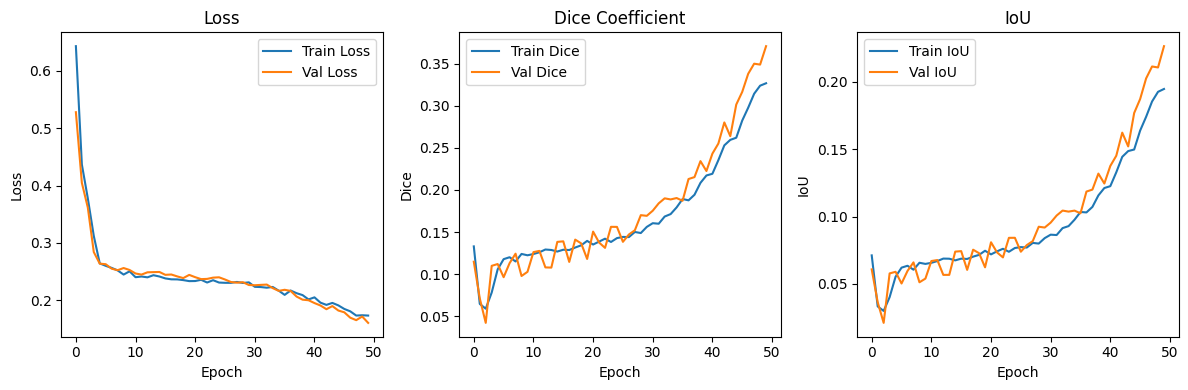

In [10]:
# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Dice Coefficient
plt.subplot(1, 3, 2)
plt.plot(history.history['dice_coefficient'], label='Train Dice')
plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

# Plot IoU
plt.subplot(1, 3, 3)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

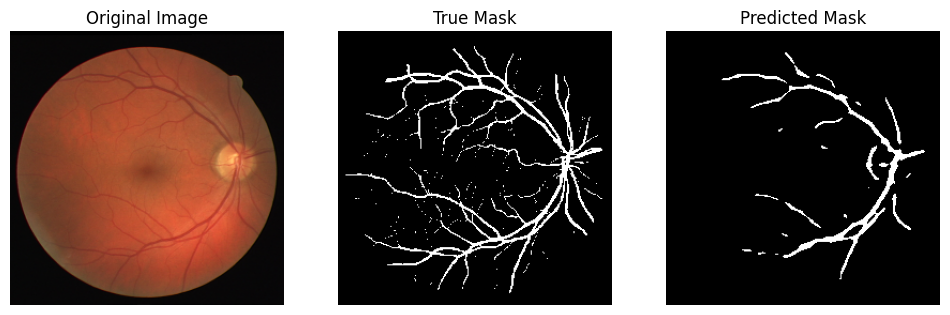

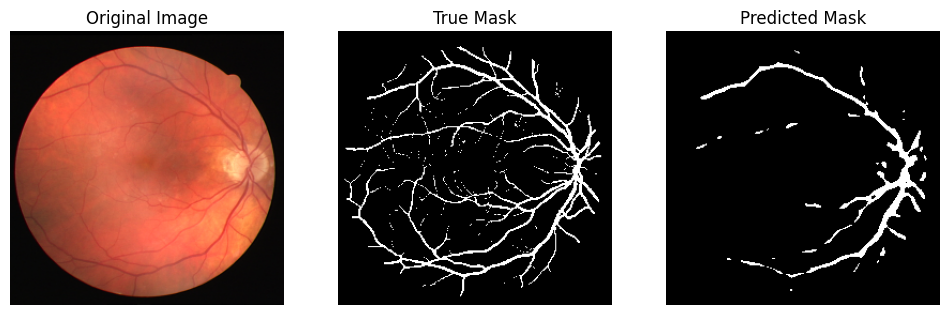

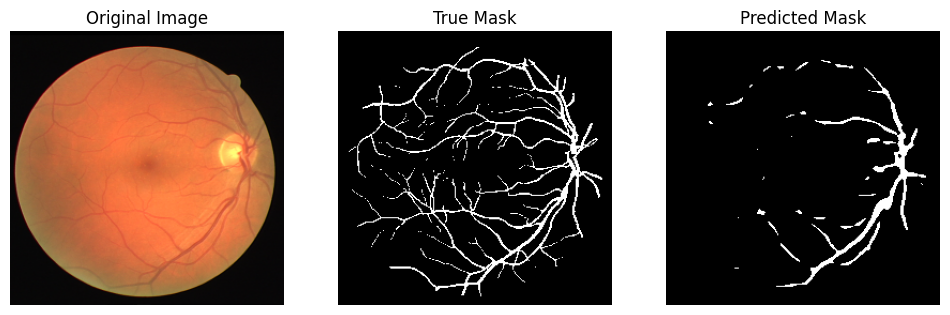

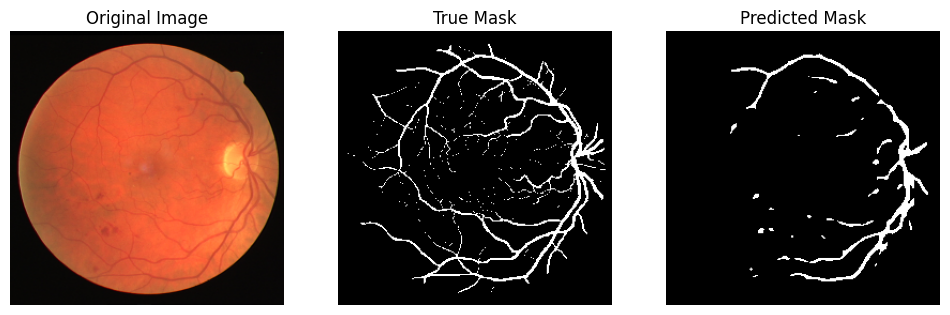

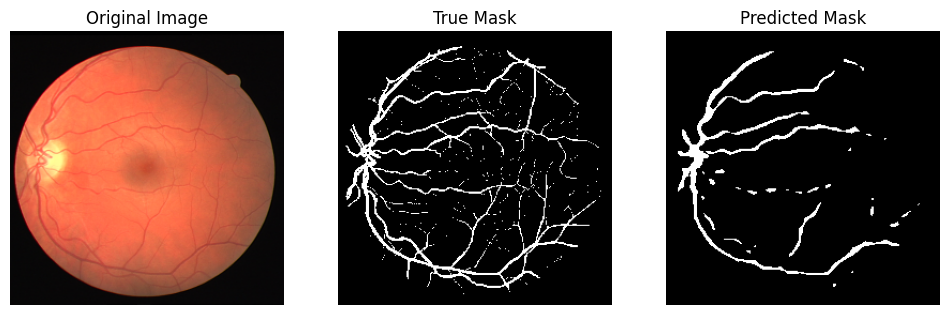

In [11]:
# Select a few test images
num_samples = 5
indices = np.random.choice(len(X_test), num_samples, replace=False)

for i in indices:
    img = X_test[i]
    true_mask = y_test[i].squeeze()
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0].squeeze()
    pred_mask = (pred_mask > 0.5).astype(np.float32)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.show()

In [12]:
# Save the entire model
model.save('unet_retina_blood_vessel_segmentation_final.h5')

# To load the model later
# model = load_model('unet_retina_blood_vessel_segmentation_final.h5', 
#                   custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})